# 2024 DASP Student Workshop on aurora-asi-lib (asilib)

References:
- [asilib docs](https://aurora-asi-lib.readthedocs.io/en/latest/index.html) --- if you're struggling with exercises, take look at the examples and API reference
- [asilib source code](http://github.com/mshumko/aurora-asi-lib)
- [DASP Student Day Resources (e.g., this notebook)](https://github.com/kylermurphy/DASP_2024)

## Setup

Since we're running on Google Colab, we will need to install asilib. Also, to speed things up, we will point the asilib data directory to Mike's Google Drive folder that already contains the TREx data. Therefore, you normally won't need this code.

First take the asilib-data Shared Google Drive folder and make a shortcut in your personal Google Drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Verify that the below ls command returns the trex/ folder.

In [ ]:
!ls "/content/drive/My Drive/2024_dasp_asi_data/"

animations  rego  themis  trex


In [ ]:
%%capture
!python -m pip install aurora-asi-lib==0.20.6

In [ ]:
!yes /content/drive/My Drive/2024_dasp_asi_data/ | python -m asilib config

Running the configuration script.
What is the aurora data directory? Press enter for the default directory at ~/asilib-data folder will be created.
aurora_asi data directory at /content/drive/My Drive/2024_dasp_asi_data already exists.


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import matplotlib.dates
from IPython.display import Video  # to display animations in a notebook

import asilib
import asilib.asi
import asilib.map

In [ ]:
print(f'asilib version: {asilib.__version__}')
print(asilib.config['ASI_DATA_DIR'])

## A substorm on 24 February 2023

We will use Univeristy of Calgary's Transition Region Explorer (TREx) imafers to look at the sudden brightning of the aurora during a substorm. Before we do that, here is a list of the TREx imager names and approximate locations.

In [ ]:
asilib.asi.trex_rgb_info()

## Analysis of single images

Let's first plot a fisheye lens, and its mapped projection from a TREx imager in Rabbit Lake (RABB)

In [ ]:
time = '2023-02-24T06:15'

asi = asilib.asi.trex_rgb('RABB', time=time)
asi.plot_fisheye()
plt.axis('off');

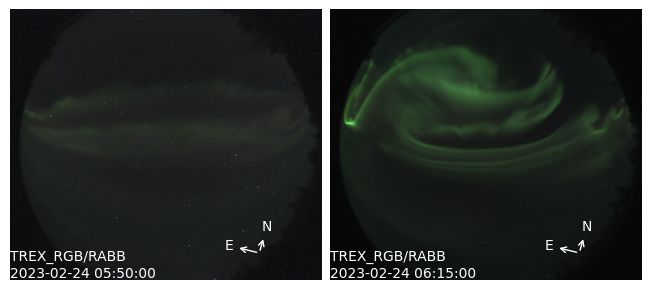

In [ ]:
rabb_asi1 = asilib.asi.trex_rgb('RABB', time='2023-02-24T05:50')
rabb_asi2 = asilib.asi.trex_rgb('RABB', time='2023-02-24T06:15')

fig, ax = plt.subplots(1, 2, layout="constrained")
rabb_asi1.plot_fisheye(ax=ax[0])
rabb_asi2.plot_fisheye(ax=ax[1])

for ax_i in ax:
  ax_i.axis('off');

While the aurora was faint at 5:50 UT, it rapidly brightened, expanded in latitude, and became more complex during the substorm expansion phase. For refrence see: Akasofu, S-I. "The development of the auroral substorm." Planetary and Space Science 12.4 (1964): 273-282.

An alternative way to visualize auroral images is to project them onto a geographic map. This is done via the skymap files, provided by the instrument teams, that map each pixel vertex to a (azimuth, elevation) and (latitude, longitude, altitude) coordinates.

In asilib, plotting images on a map is relatively straighforward, but we often need to create a map subplot first.

In [ ]:
lat_bounds=(53, 65)
lon_bounds=(-113, -92)
fig = plt.figure(layout="constrained", figsize=(10, 6))
bx = 2*[None]
bx[0] = asilib.map.create_simple_map(fig_ax=(fig, 121), lat_bounds=lat_bounds, lon_bounds=lon_bounds)
bx[1] = asilib.map.create_simple_map(fig_ax=(fig, 122), lat_bounds=lat_bounds, lon_bounds=lon_bounds)
rabb_asi1.plot_map(ax=bx[0])
rabb_asi2.plot_map(ax=bx[1]);

## Intermission. What are classes and why should I care?

The core of asilib is `asilib.Imager`. It processes the ASI data in the same way, independent of the ASI array. Thus, you only need to learn one set of methods (i.e., a function for a class) and you can work with THEMIS, REGO, and TREx images.

A brief intro to classes:

In [ ]:
class Ephemeris:
    def __init__(self, sc_id, time_range):
        """
        This class does awesome things with a satellite's ephemeris (location).
        """
        self.sc_id = sc_id
        self.time_range = time_range

    def load_data(self):
        print(f'Loading data for satellite {self.sc_id} in {self.time_range=}')
        return

    def plot_orbit(self):
        print(f'Plotting orbit for satellite {self.sc_id}.')
        return

In [ ]:
sat = Ephemeris('C', ('2023-02-24T05:50', '2023-02-24T06:00'))

In [ ]:
sat.load_data()

Loading data for satellite C in self.time_range=('2023-02-24T05:50', '2023-02-24T06:00')


In [ ]:
sat.plot_orbit()

Plotting orbit for satellite C.


In [ ]:
print(sat.sc_id, sat.time_range)

C ('2023-02-24T05:50', '2023-02-24T06:00')


## Animating multiple images

Working with single images does now show us how the aurora evolves. So let's see how to animate a sequence of images.

In [ ]:
time_range = ('2023-02-24T05:50', '2023-02-24T06:00')

fig, ax = plt.subplots(layout='constrained')
asi = asilib.asi.trex_rgb('RABB', time_range=time_range)  # note that we specify a time_range instead of time.
asi.animate_fisheye(ax=ax, overwrite=True)
plt.close()

Video(str(asilib.config["ASI_DATA_DIR"] / "animations" / asi.animation_name), embed=True) # We only need to do this in a notebook.

### Exersise \#1

Animate the above sequence of images, but onto a geographic map

In [ ]:
# Your solution here.

## Summarizing ASI images using keograms

Viewing hours of ASI images, and from multiple imagers, rapidly becomes unwieldy. Nevertheless, you can quickly judge the quality of the ASI data using a [keogram](https://en.wikipedia.org/wiki/Keogram): a plot that summarizes a series of auroral images, taken over time. Keograms are assembled by taking a slice of pixels through each image, iterating over all of the images, and assembling the slices into a new image. The vertical axis is latitude (geographic or magnetic), and horizontal axis is time.

Keograms are essential tools for auroral physists as they summarize hours worth of auroral data into a single plot. The distinct signatures in a keogram help us discern different types of aurora and seeing conditions.

In [ ]:
time_range = ('2023-02-24T05:30', '2023-02-24T06:30')

asi = asilib.asi.trex_rgb('RABB', time_range=time_range)
asi.plot_keogram()

Now we can quickly see the quiet arcs before 05:55 UT, followed by a more active substorm phase.

## Excersise \#2

Plot the same keogram, but with magnetic latitude in the vertical axis. The magnetic latitudes are calculated using the Altitude-adjusted corrected geomagnetic (AACGM) coordinates.

Citation for further reading: Shepherd, S. G. (2014), Altitude-adjusted corrected geomagnetic coordinates: Definition and functional approximations, Journal of Geophysical Research: Space Physics, 119, 7501-7521, doi:10.1002/2014JA020264.

Hint: look for the `aacgm` kwarg in the asilib docs.

In [ ]:
# Your solution here.

# Combine multiple ASIs into a mosaic

Here we intoroduce a sister class to `asilib.Imager` called `asilib.Imagers`. As you can probably guess, it combines multiple `asilib.Imager` objects to do cool stuff.

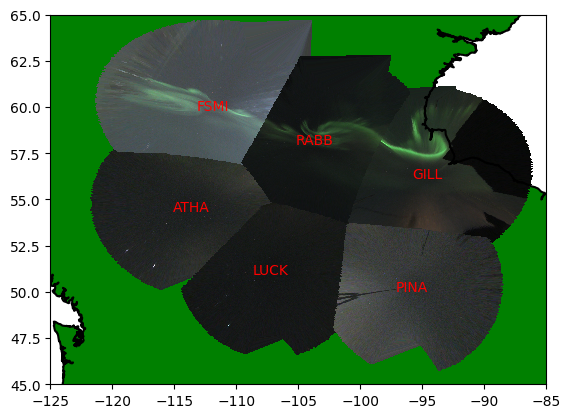

In [ ]:
time='2023-02-24T06:15'
asis = asilib.Imagers(
    [asilib.asi.trex_rgb(location_code, time=time, alt=90)
    for location_code in asilib.asi.trex_rgb_info()['location_code']]
)
dx = asilib.map.create_simple_map(
    lat_bounds=(45, 65),
    lon_bounds=(-125, -85)
)
asis.plot_map(ax=dx, min_elevation=7)

## Project

I give you two options:
1. work on your own project using asilib if you are already working on one, or
2. analyze a conjunction between Swarm and an ASI. Specifically, calculate the mean auroral intensity in a 10x10 km area at a 110 km altitude around the satellite's location. See this [example](https://aurora-asi-lib.readthedocs.io/en/latest/examples.html#asi-satellite-conjunction-movie) and this [tutorial](https://aurora-asi-lib.readthedocs.io/en/latest/tutorials/conjunctions.html) to get started.

Note: for project \#2, ideally you should map the satellite's location, orbiting at ~500 km altitude, along Earth's magnetic field lines to 110 km assumed auaoral emission altitude. However, this requires the [IRBEM library](https://github.com/PRBEM/IRBEM) which can be difficult to install. Unless you have

